# Burst rate summary
This code will extract the mean burst rate during delay of each electrode of each patient and plot a summay figure.

In [48]:
import os
import numpy as np
from ECoGBurst import SpectralBurst
from scipy import stats
from functools import reduce
import matplotlib.pyplot as plt
import copy

In [4]:
# all subjects info
sbj_ls = ['YBG','YBI','YBJ','YBN','YCP']

tone_blk_dict = {
          'YBG' : ['006'],
          'YBI' : ['013'],
          'YBJ' : ['009'],
          'YBN' : ['036'],
          'YCP' : ['035']
          }

recall_blk_dict = {
          'YBG' : ['007','008','009'],
          'YBI' : ['014'],
          'YBJ' : ['010'],
          'YBN' : ['038', '039', '040'],
          'YCP' : ['038', '039']
          }

In [5]:
# home directory
home_path = '~/Documents/MATLAB/ECoG'
home_dir  = os.path.expanduser(home_path)

In [11]:
# initiate all burst object
burst_tone_dict   = {}
burst_recall_dict = {}

for sj in sbj_ls:
    burst_tone_obj   = SpectralBurst(sbj_name = sj, 
                               blk_name = tone_blk_dict[sj], 
                               task_name = 'vis_tone_only')
    burst_recall_obj = SpectralBurst(sbj_name = sj,
                               blk_name = recall_blk_dict[sj],
                               task_name = 'vis_contrast_recall')
    
    burst_tone_dict[sj] = burst_tone_obj
    burst_recall_dict[sj] = burst_recall_obj

In [13]:
# get visual cortex electrodes list for each subject
elec_dict = {}

for sj in sbj_ls:
    burst_tone_obj   = burst_tone_dict[sj]
    burst_recall_obj = burst_recall_dict[sj]
    
    elec_list_tone   = burst_tone_obj.select_channel()
    elec_list_recall = burst_recall_obj.select_channel() 

    elect_select = reduce(np.intersect1d, (elec_list_tone, elec_list_recall))
    elect_select = elect_select.astype(int)
    elect_select_list = elect_select.tolist()
    
    elec_dict[sj] = elect_select_list

In [25]:
def mean_burst_rate(sj,ci):
    '''    
    Get mean burst rate of each electrode of each subject
    
    INPUTs:
    sj : subject name, string
    ci : electrode number, int
    
    OUTPUT:
    mean_br_tone_NBG : mean NBG burst rate of vis_tone_only
    mean_br_tone_BBG : mean BBG burst rate of vis_tone_only
    mean_br_recall_NBG : mean NBG burst rate of vis_contrast_recall
    mean_br_recall_BBG : mean BBG burst rate of vis_contrast_recall
    '''
    burst_tone_obj   = burst_tone_dict[sj]
    burst_recall_obj = burst_recall_dict[sj]
    
    NBG_burst_tone_decomp,   BBG_burst_tone_decomp   = burst_tone_obj.gamma_burst(ci, gamma_type = 'decomp')
    NBG_burst_recall_decomp, BBG_burst_recall_decomp = burst_recall_obj.gamma_burst(ci, gamma_type = 'decomp')
    
    tone_NBG_burst_rate   = np.mean(NBG_burst_tone_decomp, axis = 0)
    tone_BBG_burst_rate   = np.mean(BBG_burst_tone_decomp, axis = 0)
    recall_NBG_burst_rate = np.mean(NBG_burst_recall_decomp, axis = 0)
    recall_BBG_burst_rate = np.mean(BBG_burst_recall_decomp, axis = 0)
    
    # get the mean burst rate during delay
    mean_br_tone_NBG   = np.mean(tone_NBG_burst_rate[3000:6001])
    mean_br_tone_BBG   = np.mean(tone_BBG_burst_rate[3000:6001])
    mean_br_recall_NBG = np.mean(recall_NBG_burst_rate[3000:6001])
    mean_br_recall_BBG = np.mean(recall_BBG_burst_rate[3000:6001])
    
    return mean_br_tone_NBG, mean_br_tone_BBG, mean_br_recall_NBG, mean_br_recall_BBG

In [59]:
# get mean burst rate for each subject
result_tone_NBG_dict = {
    'YBG' : [],
    'YBI' : [],
    'YBJ' : [],
    'YBN' : [],
    'YCP' : []
    }
result_tone_BBG_dict   = copy.deepcopy(result_tone_NBG_dict)
result_recall_NBG_dict = copy.deepcopy(result_tone_NBG_dict)
result_recall_BBG_dict = copy.deepcopy(result_tone_NBG_dict)

for sj in sbj_ls:
    elec_list = elec_dict[sj]
    
    for ci in elec_list:
        mean_br_tone_NBG, mean_br_tone_BBG, mean_br_recall_NBG, mean_br_recall_BBG = mean_burst_rate(sj,ci)
        
        result_tone_NBG_dict[sj].append(mean_br_tone_NBG)
        result_tone_BBG_dict[sj].append(mean_br_tone_BBG)
        result_recall_NBG_dict[sj].append(mean_br_recall_NBG)
        result_recall_BBG_dict[sj].append(mean_br_recall_BBG)

With the above codes we have the mean burst rate of all electrodes of all subjects.

## Burst rate summary for each subject

In [159]:
def plot_individual_br(sj):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    
    for i in range(len(elec_dict[sj])):
        axs[0].scatter(['tone','recall'], [result_tone_NBG_dict[sj][i], result_recall_NBG_dict[sj][i]])
        axs[0].plot(   ['tone','recall'], [result_tone_NBG_dict[sj][i], result_recall_NBG_dict[sj][i]])
        
        axs[1].scatter(['tone','recall'], [result_tone_BBG_dict[sj][i], result_recall_BBG_dict[sj][i]])
        axs[1].plot(   ['tone','recall'], [result_tone_BBG_dict[sj][i], result_recall_BBG_dict[sj][i]])
    
    NBG_lim = max(result_tone_NBG_dict[sj] + result_recall_NBG_dict[sj])
    BBG_lim = max(result_tone_BBG_dict[sj] + result_recall_BBG_dict[sj])
    
    axs[0].set_ylim(0,1.1*NBG_lim)
    axs[0].set_ylabel('Mean NBG burst rate')
    
    axs[0].set_ylim(0,1.1*BBG_lim)    
    axs[1].set_ylabel('Mean BBG burst rate')
        
    title_text = 'Mean burst rate of ' + sj
    fig.suptitle(title_text, fontsize=16)

### YBG 
mean burst rate plot: (left = NBG burst rate, right = BBG burst rate):

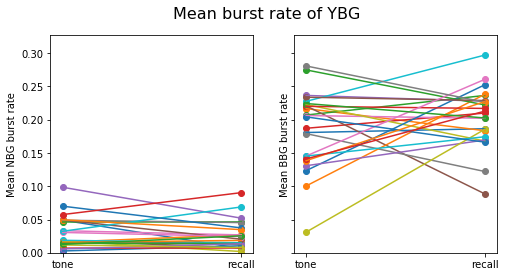

In [161]:
plot_individual_br('YBG')

## YBI
mean burst rate plot: (left = NBG burst rate, right = BBG burst rate)

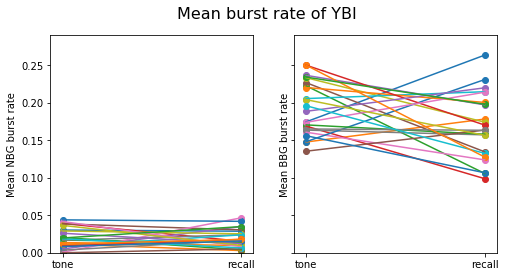

In [162]:
plot_individual_br('YBI')

### YBJ
mean burst rate plot: (left = NBG burst rate, right = BBG burst rate)

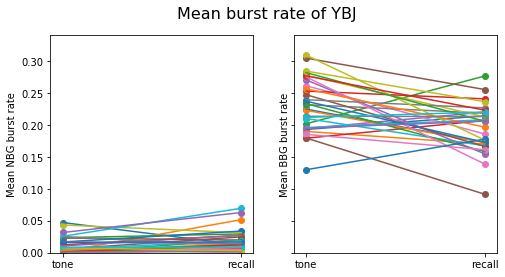

In [163]:
plot_individual_br('YBJ')

### YBN 
mean burst rate plot: (left = NBG burst rate, right = BBG burst rate)

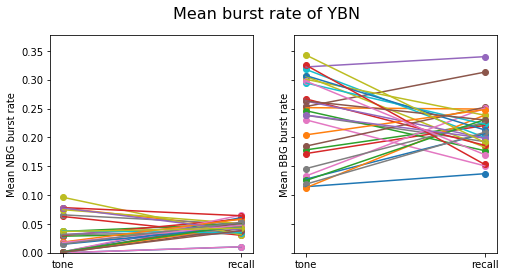

In [164]:
plot_individual_br('YBN')

### YCP 
mean burst rate plot: (left = NBG burst rate, right = BBG burst rate)

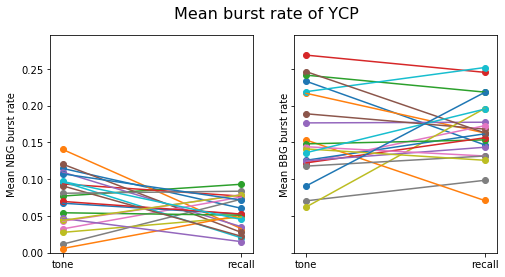

In [165]:
plot_individual_br('YCP')

## Combine all the subject together
The electrodes from a given subject are using the same color.

First, plot the **NBG** burst rates together.

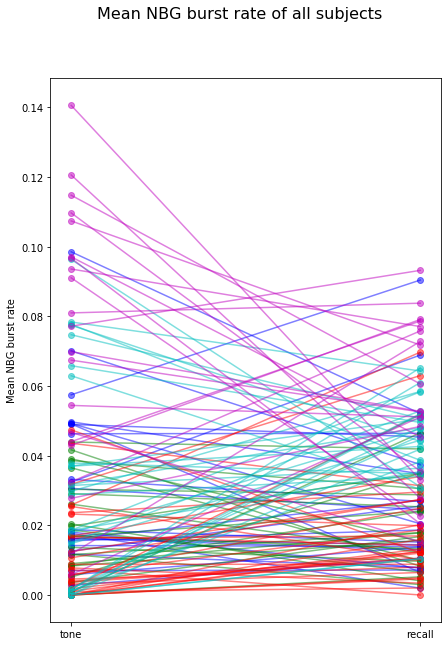

In [175]:
fig, axs = plt.subplots(figsize = (7,10))
    
color_code = ['b', 'g', 'r', 'c', 'm']

color_index = 0
for sj in sbj_ls:
       
    for i in range(len(elec_dict[sj])):
        axs.scatter(['tone','recall'], [result_tone_NBG_dict[sj][i], result_recall_NBG_dict[sj][i]], c = color_code[color_index], alpha = 0.5)
        axs.plot(   ['tone','recall'], [result_tone_NBG_dict[sj][i], result_recall_NBG_dict[sj][i]], c = color_code[color_index], alpha = 0.5)
    
    
    axs.set_ylabel('Mean NBG burst rate')

    title_text = 'Mean NBG burst rate of all subjects'
    fig.suptitle(title_text, fontsize=16)
    
    color_index += 1

Then, plot the **BBG** burst rate together

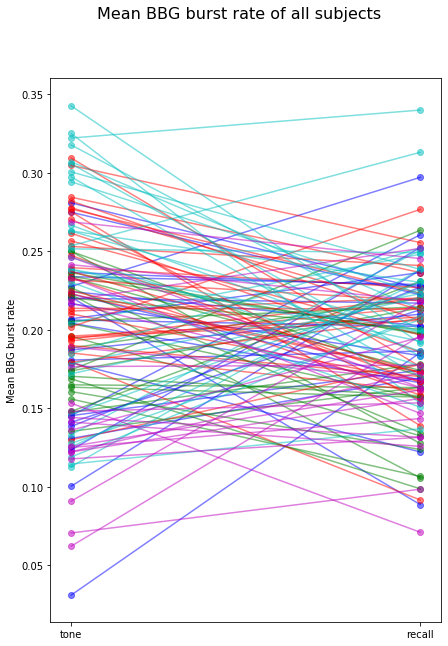

In [177]:
fig, axs = plt.subplots(figsize = (7,10))
    
color_code = ['b', 'g', 'r', 'c', 'm']

color_index = 0
for sj in sbj_ls:
       
    for i in range(len(elec_dict[sj])):
        axs.scatter(['tone','recall'], [result_tone_BBG_dict[sj][i], result_recall_BBG_dict[sj][i]], c = color_code[color_index], alpha = 0.5)
        axs.plot(   ['tone','recall'], [result_tone_BBG_dict[sj][i], result_recall_BBG_dict[sj][i]], c = color_code[color_index], alpha = 0.5)
    
    
    axs.set_ylabel('Mean BBG burst rate')

    title_text = 'Mean BBG burst rate of all subjects'
    fig.suptitle(title_text, fontsize=16)
    
    color_index += 1